In [ ]:
import re
import string
import nltk
import random

import pandas as pd
import numpy as np

from collections import Counter
from gensim import corpora
from statistics import mean
import gensim

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl 
import matplotlib.pyplot as plt

import scipy

#File import

In [ ]:
#the files s2013 and s2020 are available here: https://drive.google.com/drive/folders/1wkQN4_byG8uVf6AduA8nsC3QHN5ZOXH6?usp=sharing
import csv
filepath = './s2013.csv'
s2013 = pd.read_csv(filepath,engine='python')
filepath_2 = './s2020.csv'
s2020 = pd.read_csv(filepath_2,engine='python',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


#Construct features

In [ ]:
#text vectorizer
vectorizer = TfidfVectorizer(stop_words = None, ngram_range = (1,3)).fit(s2013['ABSTRACT'].values.astype('U'))
vectorizer2 = TfidfVectorizer(stop_words = None, ngram_range = (1,3)).fit(s2013['TITLE'].values.astype('U'))

In [ ]:
# construct sparse feature matrix
# params:
#     df: dataframe, with 'ABSTRACT' and 'TITLE' columns
#     vectorizer: sklearn text vectorizer, either TfidfVectorizer or Countvectorizer 
# return:
#     M: a sparse feature matrix that represents df's textual information (used by a predictive model)

def construct_feature_matrix(df, vectorizer, vectorizer2):
    abstract = df['ABSTRACT'].apply(lambda x: np.str_(x)).tolist()
    title = df['TITLE'].apply(lambda x: np.str_(x)).tolist()
  
    # here the dimensionality of X is len(df) x |V|
    X = vectorizer.transform(abstract)
    Y = vectorizer2.transform(title)
    Z = scipy.sparse.hstack([X,Y])
   
    return Z

In [ ]:
train_Y = s2013['CITED']
train_X = construct_feature_matrix(s2013, vectorizer, vectorizer2)
print(train_X.shape)
test_X = construct_feature_matrix(s2020, vectorizer, vectorizer2)
print(test_X.shape)

#Apply logistic regression and train

In [ ]:
model = LogisticRegression(penalty='l2',class_weight = 'balanced').fit(train_X, train_Y)
test_Y_hat = model.predict_proba(test_X)

In [ ]:
prob=[]
for i in range(0,len(test_Y_hat)):
  prob.append(test_Y_hat[i][1])

In [ ]:
#a function to merge lists
def merge(list1, list2, list3, list4):
    merged_list = []
    for i in range(max((len(list1), len(list2),len(list3),len(list4)))):
      tup = (list1[i], list2[i], list3[i],list4[i])
      merged_list.append(tup)
    return merged_list

In [ ]:
#create list of tuples and sort
merged_list = merge(s2020['REFERENCE_ID'],s2020['PMID'],s2020['CITED'],prob)
merged_list.sort(key=lambda y: y[3],reverse=True)

#Calculate Recall

In [ ]:
def calculate_recall(filepath,pmid_only,num):
  #parameters: filepath is the list computed above; 
  #       pmid_only limites whether the calculation only includes articles with PMIDs
  #       num is the number of articles to go through for each calculation e.g: num = 1000 means that we want to calculate the recall every 1000 articles
  pair = []
  filepath.sort(key=lambda y: y[3],reverse=True)
  if pmid_only == True:
    filepath=list(filter(lambda c: np.isnan(c[1]) == False, filepath))
  for i in range(1,len(filepath),num):
    tp = 0
    fn = 0
    for j in range(1,i):
      if filepath[j][2] == 1:
        tp += 1
    for k in range(i+1,len(filepath)):
      if filepath[k][2] == 1:
        fn += 1
    pair.append((i,tp/(tp+fn)))
  return pair

In [ ]:
num = 1000
recall=calculate_recall(merged_list,True,num)
recall

#Visualization

In [ ]:
x_axis = []
y_axis = []
for i in range(0,len(recall)):
  x_axis.append(recall[i][0])
  y_axis.append(recall[i][1])

In [ ]:
x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
initial=x[0]/len(y_axis)
initial

In [ ]:
#the percentile of articles going through when recall reaches 95% and 90%
x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
per_95=x[0]*num
y = [i for i in range(len(y_axis)) if y_axis[i] > 0.90]
per_90=y[0]*num

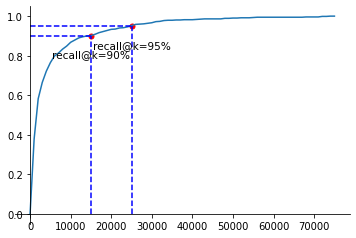

In [ ]:
#make a plot
figure = plt.figure() 
axes1 = figure.add_subplot(1,1,1)  
axes1.plot(x_axis,y_axis) 
plt.scatter([per_95],[0.95],s=25,c='r') 
plt.plot([0,per_95],[0.95,0.95],c='b',linestyle='--')
plt.plot([per_95,per_95],[0,0.95],c='b',linestyle='--')
plt.text(per_95+0.15,0.95-0.12,'recall@k=95%',ha='center',va='bottom',fontsize=10.5)
plt.scatter([per_90],[0.90],s=25,c='r') 
plt.plot([0,per_90],[0.90,0.90],c='b',linestyle='--')
plt.plot([per_90,per_90],[0,0.90],c='b',linestyle='--')
plt.text(per_90+0.15,0.90-0.12,'recall@k=90%',ha='center',va='bottom',fontsize=10.5)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
figure.show()

#Active Learning

In [ ]:
n=100
iter=5
index_list=[0]
percentile_list=[initial]
for j in range(1,iter):
  merged_list.sort(key=lambda y: y[3],reverse=True)

  #sample around 0.5 predicted score
  uncertain_sampled = []
  mid = [i for i in range(len(merged_list)) if merged_list[i][3] < 0.5]
  index_mid = mid[0]
  for i in range(int(index_mid - n/2), int(index_mid + n/2)):
    uncertain_sampled.append(merged_list[i][0])

  #add the sampled 2020 articles in the training set
  for i in range(1,len(uncertain_sampled)):
    for j in range(1,len(s2020)):
      if s2020['REFERENCE_ID'][j] == uncertain_sampled[i]:
        s2013=s2013.append(s2020.iloc[j])

  vectorizer = TfidfVectorizer(stop_words = None, ngram_range = (1,3)).fit(s2013['ABSTRACT'].values.astype('U'))
  vectorizer2 = TfidfVectorizer(stop_words = None, ngram_range = (1,3)).fit(s2013['TITLE'].values.astype('U'))

  train_Y = s2013['CITED']
  train_X = construct_feature_matrix(s2013, vectorizer,vectorizer2)
  test_X = construct_feature_matrix(s2020, vectorizer, vectorizer2)


  model = LogisticRegression(penalty='l2',class_weight = 'balanced').fit(train_X, train_Y)
  test_Y_hat = model.predict_proba(test_X)

  prob=[]
  for i in range(0,len(test_Y_hat)):
    prob.append(test_Y_hat[i][1])
  merged_list=merge(s2020['REFERENCE_ID'],s2020['PMID'],s2020['CITED'],prob)
  merged_list.sort(key=lambda y: y[3],reverse=True)

  recall=calculate_recall(merged_list,False,1000)
  x_axis = []
  y_axis = []
  for i in range(0,len(recall)):
    x_axis.append(recall[i][0])
    y_axis.append(recall[i][1])

  x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
  percentile=x[0]/len(y_axis)
  percentile_list.append(percentile)
  index_list.append(j*n)